In [165]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
import numpy as np
import os

# Chemin vers le répertoire des données
data_dir = r'C:\Users\33658\Documents\DataSet'

# Paramètres
batch_size = 3
img_height = 200
img_width = 200
epochs = 15

# Charger les données avec un split entraînement/validation
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_data = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Récupérer les noms des classes
class_names = train_data.class_names
print(f"Classes détectées : {class_names}")

# Normalisation des données (les valeurs des pixels entre 0 et 1)
normalization_layer = layers.Rescaling(1./255)

train_data = train_data.map(lambda x, y: (normalization_layer(x), y))
val_data = val_data.map(lambda x, y: (normalization_layer(x), y))


AUTOTUNE = tf.data.AUTOTUNE
train_data = train_data.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_data = val_data.cache().prefetch(buffer_size=AUTOTUNE)

# Calcul de la distribution des classes
total_counts = [0] * len(class_names)
for _, labels in train_data.unbatch():
    total_counts[labels.numpy()] += 1

print(f"Répartition des classes : {dict(zip(class_names, total_counts))}")

# Calcul des poids des classes pour gérer le déséquilibre
total_samples = sum(total_counts)
class_weights = {i: total_samples / (len(class_names) * count) for i, count in enumerate(total_counts)}
print(f"Pondérations des classes : {class_weights}")

# Définition du modèle
model = models.Sequential([
    layers.Input(shape=(img_height, img_width, 3)),  # Couche d'entrée explicite
    layers.Conv2D(128, 4, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 4, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 4, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(16, 4, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5), 
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.3),  
    layers.Dense(len(class_names), activation='softmax')  # Nombre de classes
])

# Compilation
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

# Callbacks
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

logdir = "logs"
tensorboard_callback = TensorBoard(
    log_dir=logdir,
    histogram_freq=1,
    write_images=True
)

# Entraînement
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=epochs,
    class_weight=class_weights,  # Gestion du déséquilibre des classes
    callbacks=[early_stop, tensorboard_callback]
)

# Évaluation finale
loss, accuracy = model.evaluate(val_data)
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")

# Sauvegarde du modèle
model.save("image_classification_model.keras")
print("Modèle sauvegardé.")


Found 176 files belonging to 2 classes.
Using 141 files for training.
Found 176 files belonging to 2 classes.
Using 35 files for validation.
Classes détectées : ['Sandra Bullock', 'Tom Hanks']
Répartition des classes : {'Sandra Bullock': 71, 'Tom Hanks': 70}
Pondérations des classes : {0: 0.9929577464788732, 1: 1.0071428571428571}
Epoch 1/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - accuracy: 0.4953 - loss: 0.7299 - val_accuracy: 0.4000 - val_loss: 0.6998
Epoch 2/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - accuracy: 0.5616 - loss: 0.6839 - val_accuracy: 0.4000 - val_loss: 0.6914
Epoch 3/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - accuracy: 0.5376 - loss: 0.6903 - val_accuracy: 0.6000 - val_loss: 0.6780
Epoch 4/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 0.5310 - loss: 0.7011 - val_accuracy: 0.6286 - val_loss: 0.6632
Epoch 5/15
47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - accuracy: 0.7054 - loss: 0.6837 - val_accuracy: 0.8000 - val_loss: 0.6315
Epoch 6/15
47/47 ━━━━━━━━━━━━

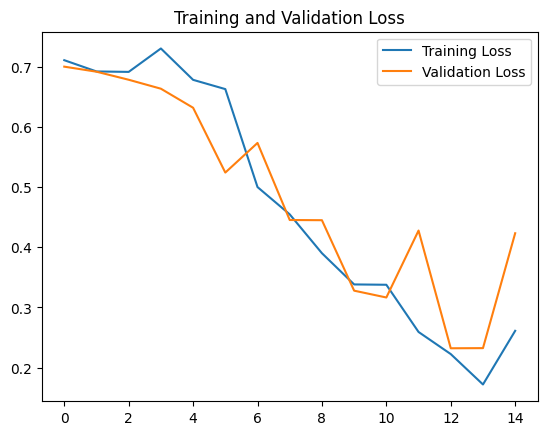

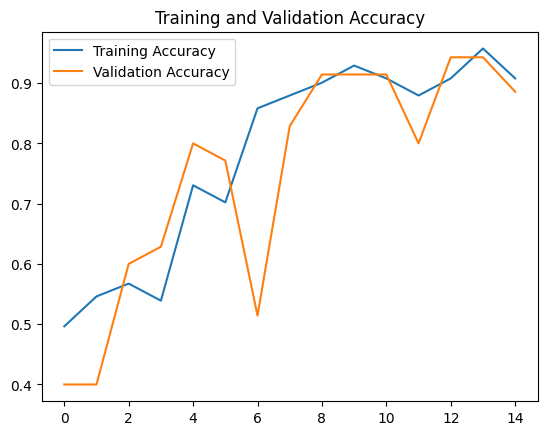

In [166]:
import matplotlib.pyplot as plt

# Courbe de perte
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Courbe de précision (si surveillée)
if 'accuracy' in history.history:
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')
    plt.show()


In [170]:
import cv2
import numpy as np
import os
from tensorflow.keras.models import load_model

# Charger le modèle sauvegardé
model_path = "image_classification_model.keras"  # Remplacez par le chemin vers votre fichier de modèle
model = load_model(model_path)
print("Modèle chargé avec succès.")

# Classes
class_names = ['Sandra Bullock','Tom Hanks']  # Remplacez par vos classes

# Chemin du dossier contenant les images
input_dir = r"C:\Users\33658\Documents\DataSet\Sandra Bullock"  # Remplacez par le chemin de votre dossier

# Prétraitement d'une image
def preprocess_image(image_path, target_size=(200, 200)):
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if image is None:
        print(f"Erreur : Impossible de charger l'image depuis {image_path}")
        return None
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convertir en RGB si nécessaire
    image = cv2.resize(image, target_size)  # Redimensionner
    image = image / 255.0  # Normalisation
    image = np.expand_dims(image, axis=0)  # Ajouter une dimension batch
    return image

# Parcourir le dossier et évaluer les images
def evaluate_folder(input_dir, class_names, model, target_size=(200, 200)):
    total_images = 0
    correct_predictions = 0

    # Parcourir les fichiers du dossier
    for file_name in os.listdir(input_dir):
        file_path = os.path.join(input_dir, file_name)

        # Vérifier si le fichier est une image
        if os.path.isfile(file_path) and file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
            # Extraire la classe réelle depuis le nom du fichier (par exemple, "Tom Cruise" dans le chemin)
            true_class = class_names.index(os.path.basename(input_dir))
            # Prétraiter l'image
            img = preprocess_image(file_path, target_size)
            if img is None:
                continue

            # Prédiction
            predictions = model.predict(img)
            predicted_class = np.argmax(predictions)

            # Comparer la prédiction avec la classe réelle
            if predicted_class == true_class:
                correct_predictions += 1
            total_images += 1

            # Afficher les résultats pour l'image
            confidence = np.max(predictions)
            print(f"Image : {file_name}")
            print(f"Classe réelle : {class_names[true_class]}")
            print(f"Classe prédite : {class_names[predicted_class]}")
            print(f"Confiance : {confidence:.2f}")
            print("-" * 50)

    # Résumé des résultats
    accuracy = (correct_predictions / total_images) * 100 if total_images > 0 else 0
    print(f"Total d'images évaluées : {total_images}")
    print(f"Prédictions correctes : {correct_predictions}")
    print(f"Précision globale : {accuracy:.2f}%")

# Exemple d'utilisation
evaluate_folder(input_dir, class_names, model)


Modèle chargé avec succès.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
Image : 001_5ef3e95c_face_1.jpg
Classe réelle : Sandra Bullock
Classe prédite : Sandra Bullock
Confiance : 1.00
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Image : 002_24fab375_face_2.jpg
Classe réelle : Sandra Bullock
Classe prédite : Sandra Bullock
Confiance : 1.00
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Image : 004_78847874_face_1.jpg
Classe réelle : Sandra Bullock
Classe prédite : Sandra Bullock
Confiance : 1.00
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Image : 005_b0b4e2fa_face_1.jpg
Classe réelle : Sandra Bullock
Classe prédite : Sandra Bullock
Confiance : 1.00
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Image : 006_96ea405c_face_1.jpg
Classe réelle : Sandra Bullock
Classe prédite : Sandra Bullock
Confiance : 1.00
------------------